In [470]:
import warnings
import pandas as pd
import mplfinance as mpf
import numpy as np
import random
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
import os

from trainer import fit
from datasets import SiameseMNIST, TripletMNIST, BalancedBatchSampler
from metrics import AccumulatedAccuracyMetric, AverageNonzeroTripletsMetric
from networks import EmbeddingNet, ClassificationNet, SiameseNet, TripletNet
from losses import ContrastiveLoss, TripletLoss, OnlineContrastiveLoss, OnlineTripletLoss

from utils import HardNegativePairSelector  # Strategies for selecting pairs within a minibatch
from utils import RandomNegativeTripletSelector  # Strategies for selecting triplets within a minibatch
from utils import set_all_seeds
warnings.filterwarnings("ignore")

In [471]:
set_all_seeds(42)

In [472]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [473]:
buy_patterns_clusters = np.load('/Users/viktor_nemchenko/siamese-triplet/data/buy_patterns_clusters.npy')
buy_patterns = np.load('/Users/viktor_nemchenko/siamese-triplet/data/buy_patterns.npy')
sell_patterns_clusters = np.load('/Users/viktor_nemchenko/siamese-triplet/data/sell_patterns_clusters.npy')
sell_patterns = np.load('/Users/viktor_nemchenko/siamese-triplet/data/sell_patterns.npy')

print(f'buy_patterns_clusters shape: {buy_patterns_clusters.shape}')
print(f'buy_patterns shape: {buy_patterns.shape}')
print(f'sell_patterns_clusters shape: {sell_patterns_clusters.shape}')
print(f'sell_patterns shape: {sell_patterns.shape}')

buy_patterns_clusters shape: (30,)
buy_patterns shape: (30, 60, 5)
sell_patterns_clusters shape: (25,)
sell_patterns shape: (25, 60, 5)


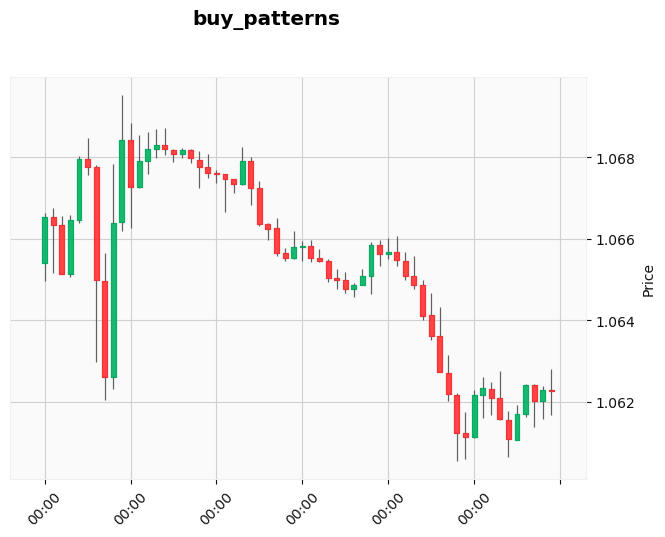

In [474]:
k_num = 11
data_buy = pd.DataFrame({
    'Date': [i for i in range(buy_patterns[:,:,0][0].shape[0])],
    'Open': buy_patterns[:,:,0][k_num],
    'High': buy_patterns[:,:,1][k_num],
    'Low': buy_patterns[:,:,2][k_num],
    'Close': buy_patterns[:,:,3][k_num],
    'Volume': buy_patterns[:,:,4][k_num]
})

data_buy['Date'] = pd.to_datetime(data_buy['Date'])
data_buy.set_index('Date', inplace=True)

mpf.plot(data_buy, type='candle', style='yahoo', title='buy_patterns')


In [475]:
buy_patterns_clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

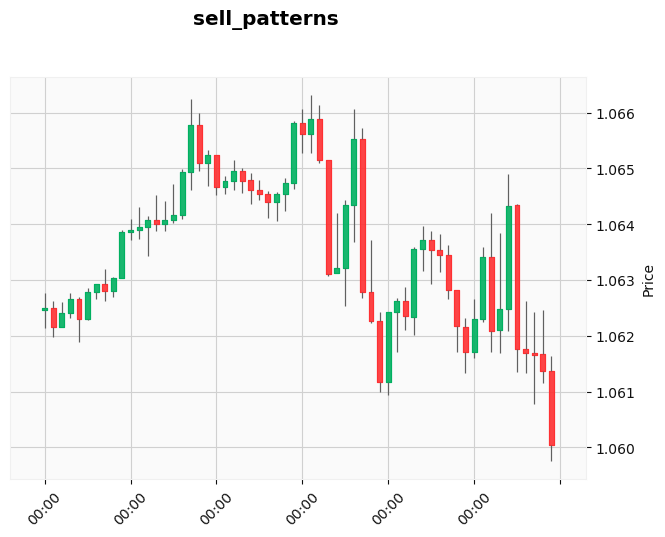

In [476]:
k_num = 11
data_sell = pd.DataFrame({
    'Date': [i for i in range(buy_patterns[:,:,0][0].shape[0])],
    'Open': sell_patterns[:,:,0][k_num],
    'High': sell_patterns[:,:,1][k_num],
    'Low': sell_patterns[:,:,2][k_num],
    'Close': sell_patterns[:,:,3][k_num],
    'Volume': sell_patterns[:,:,4][k_num]
})


data_sell['Date'] = pd.to_datetime(data_sell['Date'])
data_sell.set_index('Date', inplace=True)
data_sell['Open']

mpf.plot(data_sell, type='candle', style='yahoo', title='sell_patterns')


In [477]:
sell_patterns_clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [478]:
n_classes = 4
mnist_classes = ['0', '1', '2', '3']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
cuda = torch.cuda.is_available()

def plot_embeddings(embeddings, targets, title=None, xlim=None, ylim=None):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)
    plt.title(title)
    plt.show()

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [479]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

x = np.concatenate([buy_patterns, sell_patterns])
y = np.concatenate([buy_patterns_clusters, sell_patterns_clusters+2])

scaler = StandardScaler()
# scaled_data = scaler.fit_transform(x.reshape(-1, 5)).reshape(x.shape)
# scaled_data = normalize(x.reshape(50, -1), norm='l2', axis=1).reshape(x.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    shuffle=True, stratify=y, random_state=29)

x_train = scaler.fit_transform(x_train.reshape(-1, 5)).reshape(x_train.shape).reshape(44, 1, 60, 5)
x_test = scaler.transform(x_test.reshape(-1, 5)).reshape(x_test.shape).reshape(11, 1, 60, 5)

# x_train =  normalize(x_train.reshape(50, -1), norm='l2', axis=1).reshape(x_train.shape).reshape(44, 1, 60, 5)
# x_test = normalize(x_test.reshape(50, -1), norm='l2', axis=1).reshape(x_test.shape).reshape(11, 1, 60, 5)


train_dataset = [(torch.from_numpy(x_train[i]).double(), torch.tensor(y_train[i], dtype=torch.long)) for i in range(len(y_train))]
test_dataset = [(torch.from_numpy(x_test[i]).double(), torch.tensor(y_test[i], dtype=torch.long)) for i in range(len(y_test))]

x_train = torch.from_numpy(x_train).double()
x_test = torch.from_numpy(x_test).double()
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)


1. Baseline - classification with softmax:
Train: [0/44 (0%)]	Loss: 1.402406	Accuracy: 20.454545454545453

Epoch: 1/20. Train set: Average loss: 1.4024	Accuracy: 20.454545454545453
Epoch: 1/20. Validation set: Average loss: 1.2310	Accuracy: 54.54545454545455
Train: [0/44 (0%)]	Loss: 1.151263	Accuracy: 45.45454545454545

Epoch: 2/20. Train set: Average loss: 1.1513	Accuracy: 45.45454545454545
Epoch: 2/20. Validation set: Average loss: 3.2059	Accuracy: 54.54545454545455
Train: [0/44 (0%)]	Loss: 0.884323	Accuracy: 61.36363636363637

Epoch: 3/20. Train set: Average loss: 0.8843	Accuracy: 61.36363636363637
Epoch: 3/20. Validation set: Average loss: 2.3847	Accuracy: 54.54545454545455
Train: [0/44 (0%)]	Loss: 0.804278	Accuracy: 63.63636363636363

Epoch: 4/20. Train set: Average loss: 0.8043	Accuracy: 63.63636363636363
Epoch: 4/20. Validation set: Average loss: 1.8121	Accuracy: 54.54545454545455
Train: [0/44 (0%)]	Loss: 0.727896	Accuracy: 63.63636363636363

Epoch: 5/20. Train set: Average los

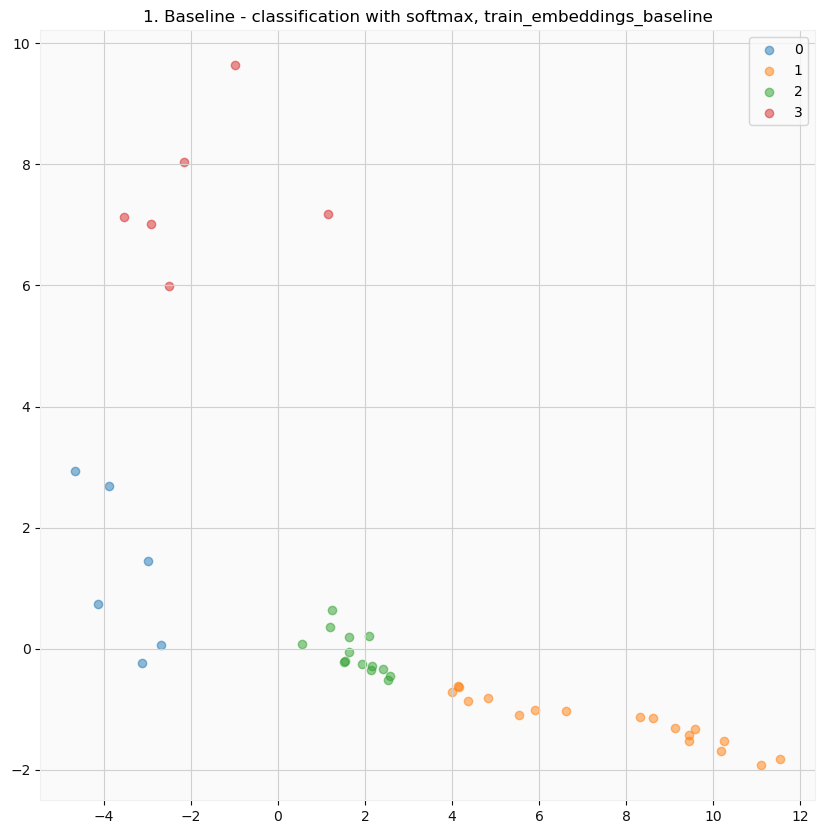

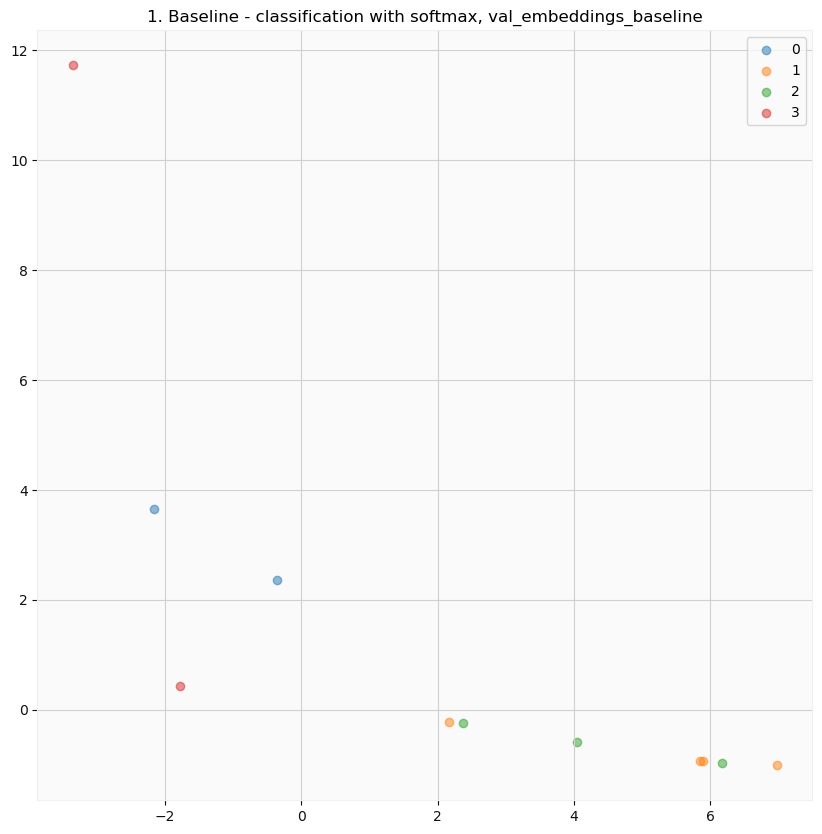

In [480]:
# Baseline: Classification with softmax
# We'll train the model for classification and use outputs of penultimate layer as embeddings
# Set up data loaders
title = '1. Baseline - classification with softmax'
print(f'\n{title}:')
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
embedding_net = EmbeddingNet().double()
model = ClassificationNet(embedding_net, n_classes=n_classes).double()
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval,
    metrics=[AccumulatedAccuracyMetric()])

train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline, f'{title}, train_embeddings_baseline')
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline, f'{title}, val_embeddings_baseline')


2. Siamese network:
Train: [0/44 (0%)]	Loss: 0.160606

Epoch: 1/20. Train set: Average loss: 0.1606
Epoch: 1/20. Validation set: Average loss: 0.1475
Train: [0/44 (0%)]	Loss: 1.330951

Epoch: 2/20. Train set: Average loss: 1.3310
Epoch: 2/20. Validation set: Average loss: 0.1105
Train: [0/44 (0%)]	Loss: 0.233961

Epoch: 3/20. Train set: Average loss: 0.2340
Epoch: 3/20. Validation set: Average loss: 0.0922
Train: [0/44 (0%)]	Loss: 0.121213

Epoch: 4/20. Train set: Average loss: 0.1212
Epoch: 4/20. Validation set: Average loss: 0.0927
Train: [0/44 (0%)]	Loss: 0.141035

Epoch: 5/20. Train set: Average loss: 0.1410
Epoch: 5/20. Validation set: Average loss: 0.0897
Train: [0/44 (0%)]	Loss: 0.124433

Epoch: 6/20. Train set: Average loss: 0.1244
Epoch: 6/20. Validation set: Average loss: 0.0868
Train: [0/44 (0%)]	Loss: 0.127435

Epoch: 7/20. Train set: Average loss: 0.1274
Epoch: 7/20. Validation set: Average loss: 0.0864
Train: [0/44 (0%)]	Loss: 0.079465

Epoch: 8/20. Train set: Average lo

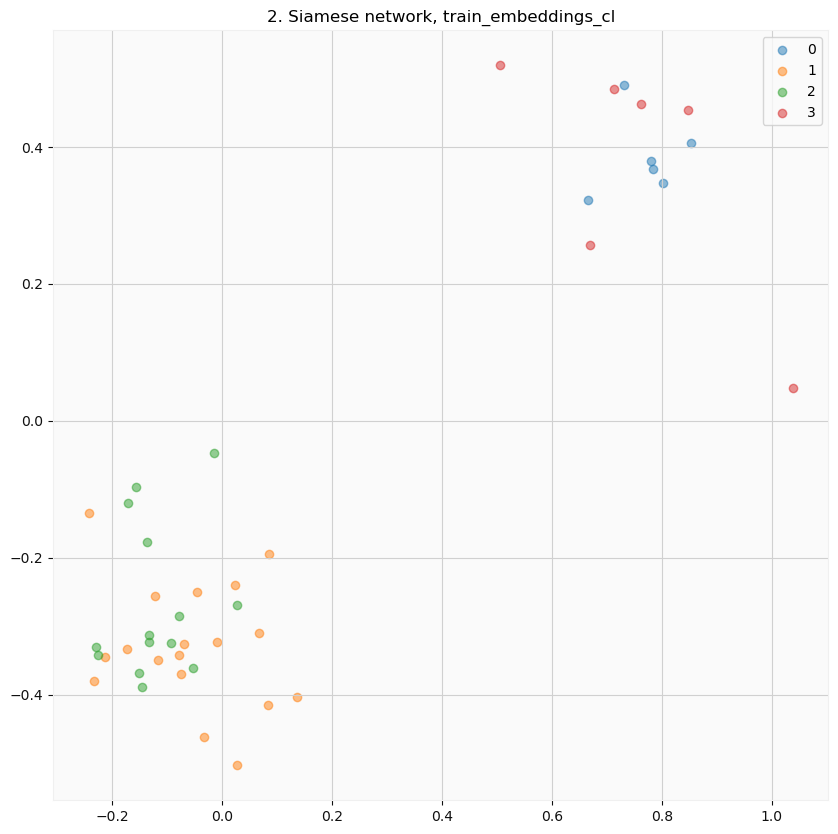

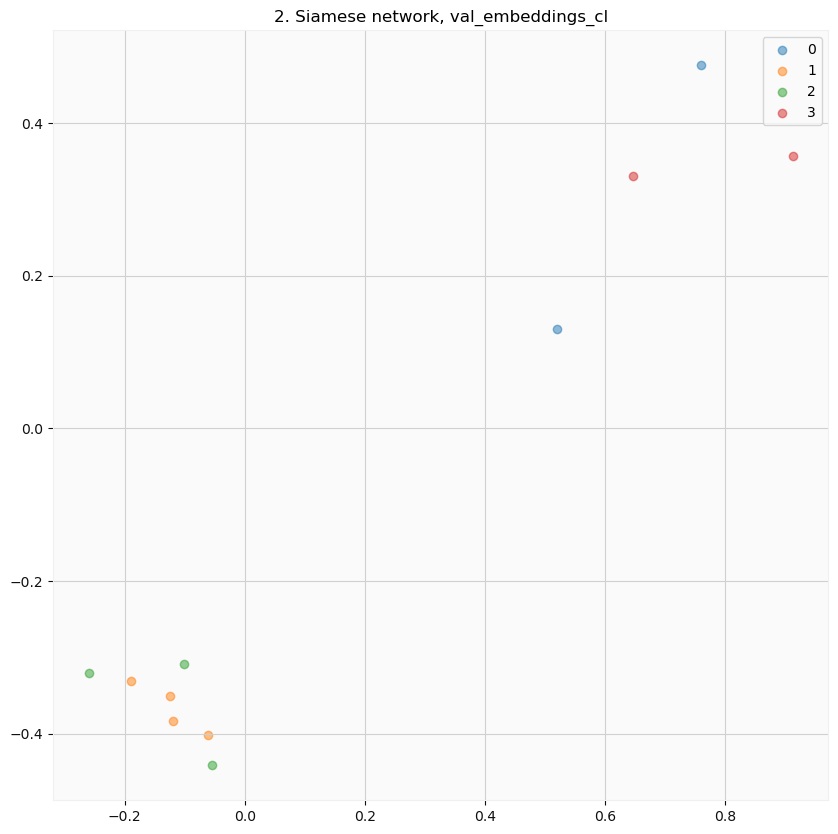

In [481]:
cuda = torch.cuda.is_available()

title = '2. Siamese network'
print(f'\n{title}:')
siamese_train_dataset = SiameseMNIST(x=x_train, y=y_train, train=True) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(x=x_test, y=y_test, train=False)
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)


# Set up the network and training parameters
margin = 1.
embedding_net = EmbeddingNet().double()
model = SiameseNet(embedding_net).double()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

fit(siamese_train_loader, siamese_test_loader, model,
     loss_fn, optimizer, scheduler, n_epochs, cuda,
       log_interval)

train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl, f'{title}, train_embeddings_cl')
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl, f'{title}, val_embeddings_cl')


3. Triplet network:
Train: [0/44 (0%)]	Loss: 1.023987

Epoch: 1/40. Train set: Average loss: 1.0240
Epoch: 1/40. Validation set: Average loss: 0.8775
Train: [0/44 (0%)]	Loss: 2.590282

Epoch: 2/40. Train set: Average loss: 2.5903
Epoch: 2/40. Validation set: Average loss: 0.9256
Train: [0/44 (0%)]	Loss: 0.654402

Epoch: 3/40. Train set: Average loss: 0.6544
Epoch: 3/40. Validation set: Average loss: 0.4107
Train: [0/44 (0%)]	Loss: 0.405345

Epoch: 4/40. Train set: Average loss: 0.4053
Epoch: 4/40. Validation set: Average loss: 0.1690
Train: [0/44 (0%)]	Loss: 0.262813

Epoch: 5/40. Train set: Average loss: 0.2628
Epoch: 5/40. Validation set: Average loss: 0.1293
Train: [0/44 (0%)]	Loss: 0.060177

Epoch: 6/40. Train set: Average loss: 0.0602
Epoch: 6/40. Validation set: Average loss: 0.0907
Train: [0/44 (0%)]	Loss: 0.123832

Epoch: 7/40. Train set: Average loss: 0.1238
Epoch: 7/40. Validation set: Average loss: 0.0916
Train: [0/44 (0%)]	Loss: 0.261512

Epoch: 8/40. Train set: Average lo

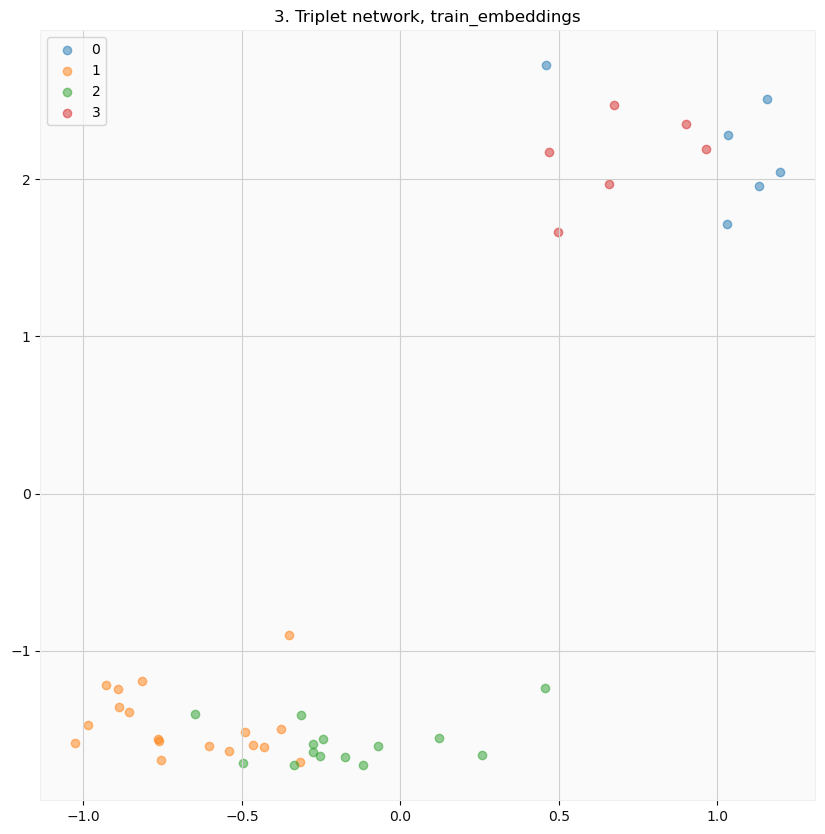

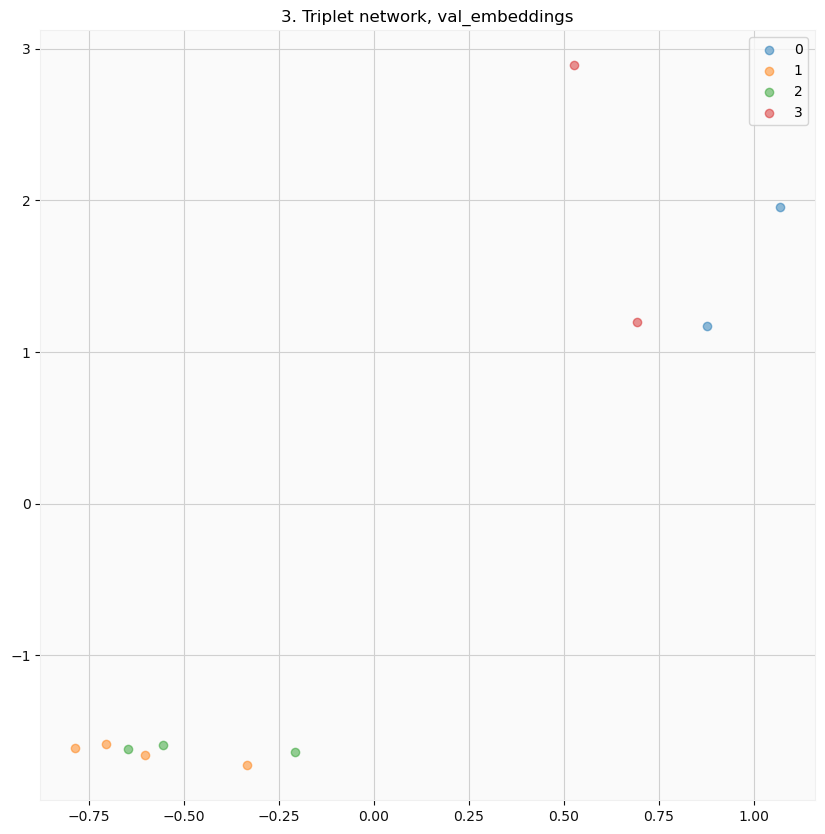

In [482]:
# Triplet network
# We'll train a triplet network, that takes an anchor, positive (same class as anchor)
# and negative (different class than anchor) examples.
# The objective is to learn embeddings such that the anchor is closer to the positive example
# than it is to the negative example by some margin value.
title = '3. Triplet network'
print(f'\n{title}:')
# Set up data loaders
triplet_train_dataset = TripletMNIST(x=x_train, y=y_train, train=True) # Returns triplets of images
triplet_test_dataset = TripletMNIST(x=x_test, y=y_test, train=False)
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
margin = 1.
embedding_net = EmbeddingNet().double()
model = TripletNet(embedding_net).double()
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 40
log_interval = 100

fit(triplet_train_loader, triplet_test_loader, model,
     loss_fn, optimizer, scheduler, n_epochs, cuda,
       log_interval)

train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl, f'{title}, train_embeddings')
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl, f'{title}, val_embeddings')


4. Online pair selection - negative mining:
Train: [0/44 (0%)]	Loss: 0.506154

Epoch: 1/40. Train set: Average loss: 1.5115
Epoch: 1/40. Validation set: Average loss: 0.4882
Train: [0/44 (0%)]	Loss: 0.401775

Epoch: 2/40. Train set: Average loss: 0.4988
Epoch: 2/40. Validation set: Average loss: 0.4845
Train: [0/44 (0%)]	Loss: 0.566115

Epoch: 3/40. Train set: Average loss: 0.4818
Epoch: 3/40. Validation set: Average loss: 0.4607
Train: [0/44 (0%)]	Loss: 0.336192

Epoch: 4/40. Train set: Average loss: 0.3470
Epoch: 4/40. Validation set: Average loss: 0.4818
Train: [0/44 (0%)]	Loss: 0.339960

Epoch: 5/40. Train set: Average loss: 0.3160
Epoch: 5/40. Validation set: Average loss: 0.4471
Train: [0/44 (0%)]	Loss: 0.215699

Epoch: 6/40. Train set: Average loss: 0.3073
Epoch: 6/40. Validation set: Average loss: 0.4380
Train: [0/44 (0%)]	Loss: 0.260501

Epoch: 7/40. Train set: Average loss: 0.3298
Epoch: 7/40. Validation set: Average loss: 0.4268
Train: [0/44 (0%)]	Loss: 0.166952

Epoch: 8/4

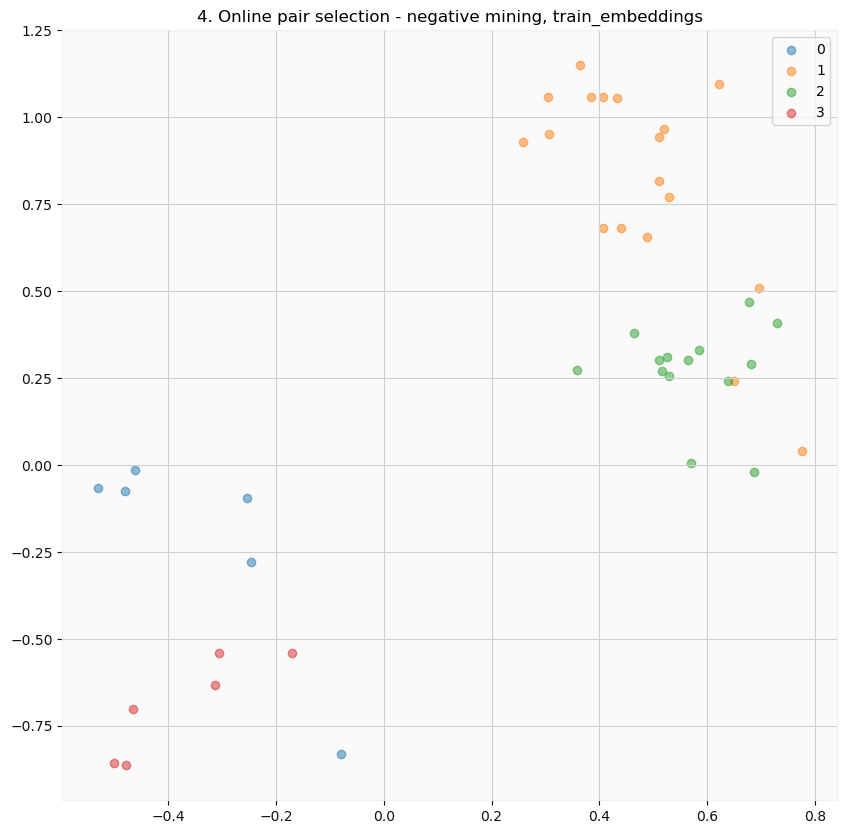

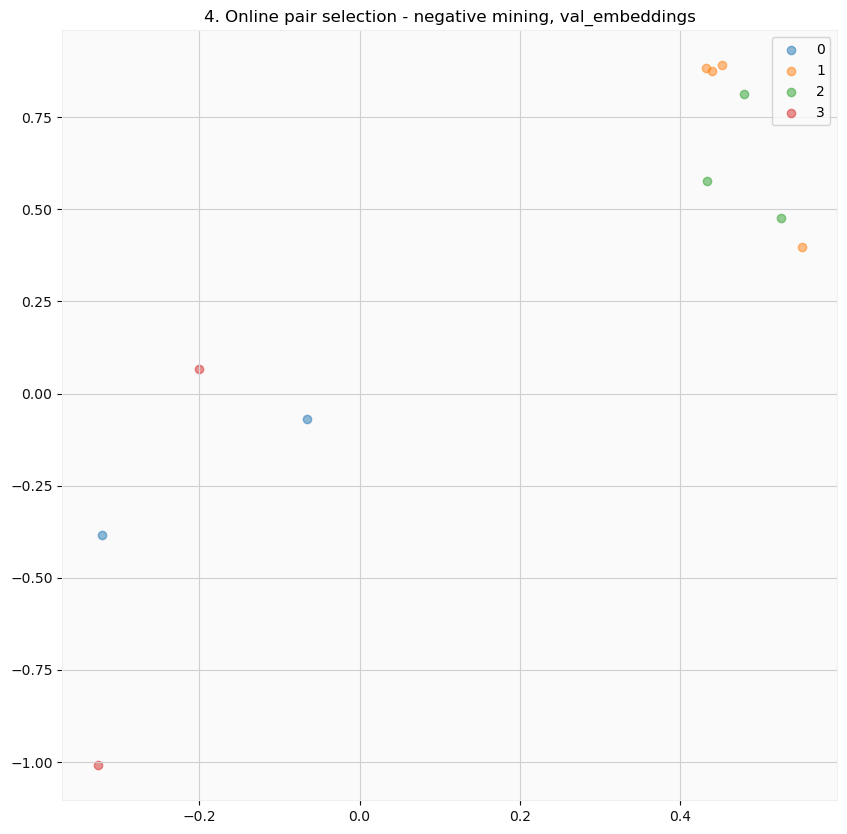

In [483]:
## Online pair selection
## Steps
# 1. Create BalancedBatchSampler - samples N  classes and M samples datasets.py
# 2. Create data loaders with the batch sampler Define embedding (mapping) network f(x) - EmbeddingNet from networks.py
# 3. Define a PairSelector that takes embeddings and original labels and returns valid pairs within a minibatch
# 4. Define OnlineContrastiveLoss that will use a PairSelector and compute ContrastiveLoss on such pairs
# 5. Train the network!
title = '4. Online pair selection - negative mining'
print(f'\n{title}:')
# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(y_train, n_classes=4, n_samples=4)
test_batch_sampler = BalancedBatchSampler(y_test, n_classes=4, n_samples=2)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
margin = 1.
embedding_net = EmbeddingNet().double()
model = embedding_net.double()
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 40
log_interval = 50

fit(online_train_loader, online_test_loader, model,
     loss_fn, optimizer, scheduler, n_epochs, cuda,
       log_interval)

train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, f'{title}, train_embeddings')
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl, f'{title}, val_embeddings')


5. Online triplet selection - negative mining:
Train: [0/44 (0%)]	Loss: 0.310020

Epoch: 1/50. Train set: Average loss: 0.3100
Epoch: 1/50. Validation set: Average loss: 0.0098
Train: [0/44 (0%)]	Loss: 0.536222

Epoch: 2/50. Train set: Average loss: 0.5362
Epoch: 2/50. Validation set: Average loss: 0.0085
Train: [0/44 (0%)]	Loss: 0.759010

Epoch: 3/50. Train set: Average loss: 0.7590
Epoch: 3/50. Validation set: Average loss: 0.0054
Train: [0/44 (0%)]	Loss: 0.545328

Epoch: 4/50. Train set: Average loss: 0.5453
Epoch: 4/50. Validation set: Average loss: 0.0108
Train: [0/44 (0%)]	Loss: 0.357612

Epoch: 5/50. Train set: Average loss: 0.3576
Epoch: 5/50. Validation set: Average loss: 0.0109
Train: [0/44 (0%)]	Loss: 0.150363

Epoch: 6/50. Train set: Average loss: 0.1504
Epoch: 6/50. Validation set: Average loss: 0.0093
Train: [0/44 (0%)]	Loss: 0.203819

Epoch: 7/50. Train set: Average loss: 0.2038
Epoch: 7/50. Validation set: Average loss: 0.0204
Train: [0/44 (0%)]	Loss: 0.061750

Epoch: 

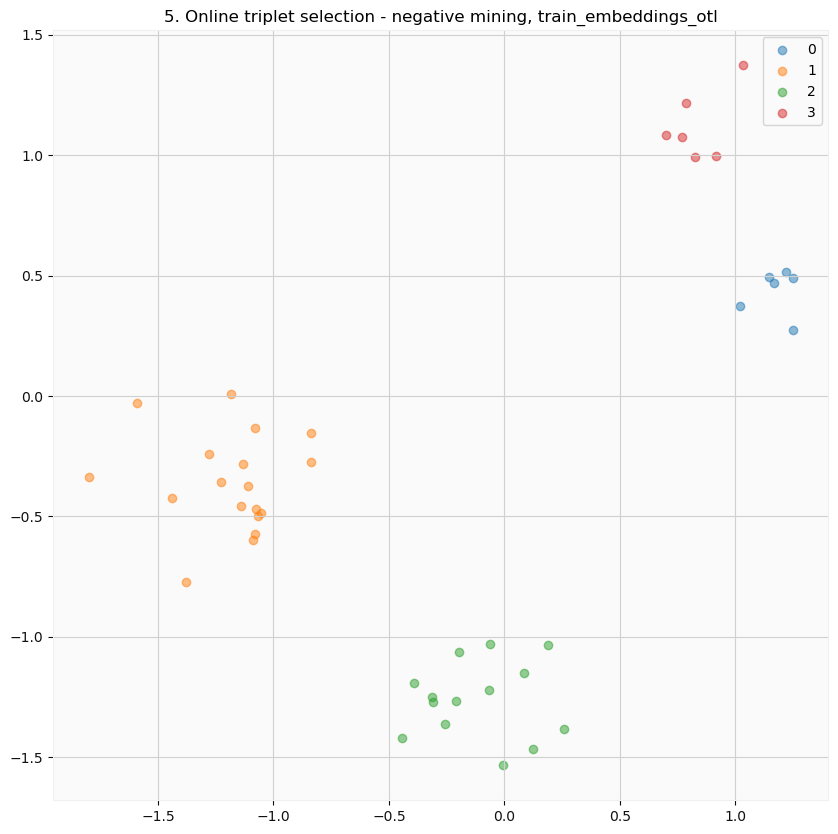

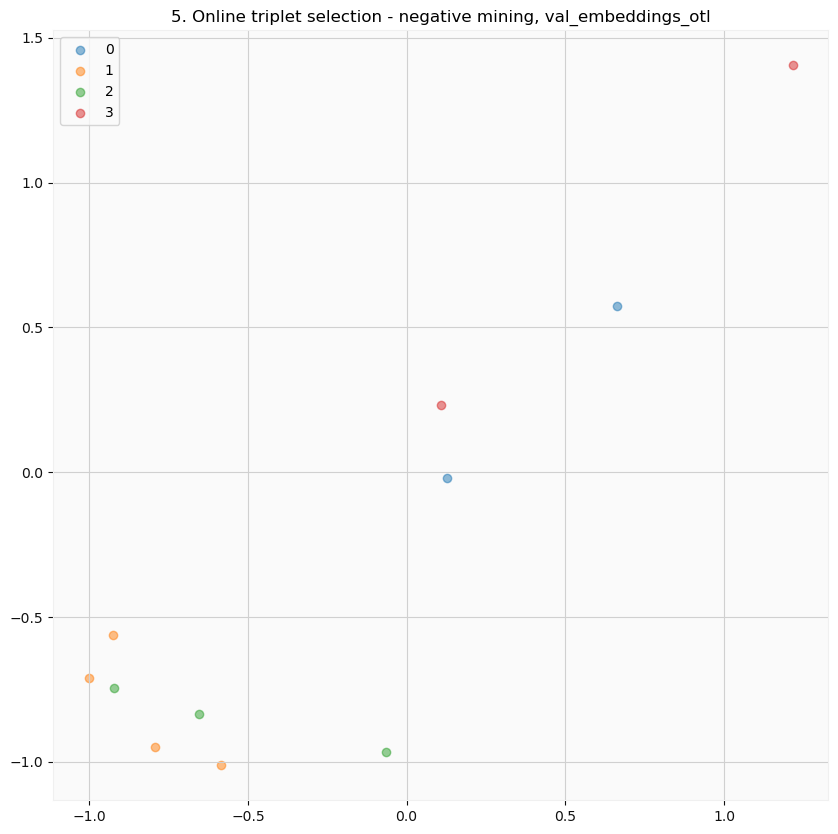

In [484]:
from networks import EmbeddingNet, ClassificationNet, SiameseNet, TripletNet
from utils import HardestNegativeTripletSelector
## Online triplet selection
## Steps
# 1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
# 2. Create data loaders with the batch sampler
# 3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
# 4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
# 5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
# 6. Train the network!

title = '5. Online triplet selection - negative mining'
print(f'\n{title}:')
set_all_seeds(54)
# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(y_train, n_classes=4, n_samples=8)
test_batch_sampler = BalancedBatchSampler(y_test, n_classes=4, n_samples=2)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
margin = 0.01
embedding_net = EmbeddingNet().double()
model = embedding_net.double()
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin)) 
lr = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50
log_interval = 50

fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl, f'{title}, train_embeddings_otl')
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl, f'{title}, val_embeddings_otl')